# Causal Discovery and Inference

**"Correlation is not causation."**

The age-old adage "correlation is not causation" highlights a critical limitation in data analysis. Traditionally, we rely on correlations to understand how variables are associated. However, correlation simply shows a link, not a cause-and-effect relationship.

A classic example is the link between ice cream sales and shark attacks. Data might show both rise during summer, tempting us to believe ice cream consumption somehow causes shark attacks! But the real culprit is likely a lurking third variable: hot weather. Hot weather naturally leads to people buying more ice cream and spending more time at the beach, increasing the chance of encountering sharks.

This is where causal discovery and inference come in. These fields aim to bridge the gap beyond correlation and understand true cause-and-effect relationships. They work in tandem:

- **Causal discovery** is like detective work. It  focuses on identifying  causal relationships from data. Imagine you have a bunch of observations: ice cream sales go up, and so do sunburn rates. Causal discovery helps you figure out if sunshine causes people to buy ice cream (direct cause) or if both are caused by a hot summer (indirect cause).

- **Causal inference** goes a step further. Once you have a suspected causal relationship, causal inference estimates the magnitude or strength of that effect. Continuing the ice cream example, causal inference helps you determine how much sunburn rates actually increase ice cream sales (by a specific percentage or amount).

By moving beyond correlation with causal inference, we can now make a more definitive statement: "X causes Y" instead of just "X is associated with Y". Understanding true cause-and-effect relationships is crucial for effective decision-making across various fields. In medicine, it can determine a new drug's true effectiveness. In marketing, it can reveal the factors that truly drive sales.

This notebook will delve into the **theory behind causal discovery and inference, explore some algorithms used for these tasks, and introduce Python libraries** that can help you perform causal analysis.

# 1. Causal Graph

A causal graph, also known as a causal Bayesian network or causal DAG (Directed Acyclic Graph), is a graphical representation of causal relationships between variables. In a causal graph, nodes represent variables, and directed edges between nodes indicate causal relationships, showing the direction of influence from one variable to another. The graph is acyclic, meaning there are no loops where a variable directly or indirectly influences itself.

Causal graphs are used in causal inference to model and understand causal relationships in complex systems. They help in identifying causal pathways, determining which variables are direct causes of others, and estimating the effects of interventions or changes in variables.

Let's take a look at them now.

## 1.1. Introduction to Basic Graphs

To grasp the fundamentals of a basic graph and its associated terms, we can examine the following graph, which illustrates the definition of each component in a basic graph:

- **Nodes:** You have nodes V, specifically: V = {X, Y, Z}
- **Edges:** You also have edges E. These edges connect pairs of nodes, where each node represents a (random) variable.
- **Graph Representation:** The combination of edges and nodes forms a graph **G = (V, E)**

Please note that for **creating causal graphs, the daft library can be utilized**. This Python package uses matplotlib to generate precise probabilistic graphical models, suitable for publication in journals or on the internet. For the documentation about drawing causal graph using daft library, you can check it <a href="https://docs.daft-pgm.org/en/latest/api/#the-pgm-object">here.</a>

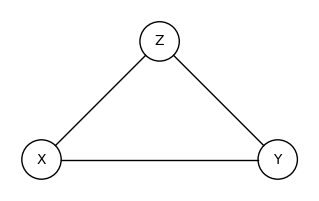

In [11]:
import matplotlib.pyplot as plt
from daft import PGM

V = PGM(grid_unit=3.0)

# add nodes X, Y, and Z
V.add_node("X", "X", 1, 1)
V.add_node("Y", "Y", 3, 1)
V.add_node("Z", "Z", 2, 2)

# after that, we can crete the edges to connect pairs of nodes
V.add_edge("X", "Y", directed=False)
V.add_edge("Y", "Z", directed=False)
V.add_edge("X", "Z", directed=False)

V.render()
plt.show()

## 1.2. Directed Acyclic Graphs (DAG)

In order to represent causal relationships, we must transition from undirected to directed graphs. The previous graph illustrates an undirected graph. By using directed graphs as follows, we can **indicate relationships between nodes through kinship relations, referring to nodes as parents, children, ancestors, and descendants.**

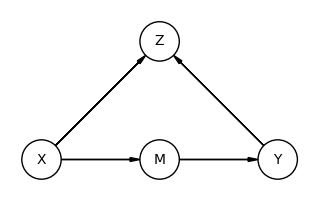

In [12]:
V = PGM(grid_unit=3.0)

V.add_node("X", "X", 1, 1)
V.add_node("Y", "Y", 3, 1)
V.add_node("Z", "Z", 2, 2)
# let's add M now to the previous graph to be able to show a more complex graph
V.add_node("M", "M", 2, 1)

# to move from undirected to directed, we can skip defining "directed" parameter
# the arrow moves from the first node to the second node defined in the parameter
V.add_edge("X", "M")
V.add_edge("M", "Y")
V.add_edge("Y", "Z")
V.add_edge("X", "Z")

V.render()
plt.show()

There are additional terms that are important for you to grasp:

- **Adjacent:** When two nodes are connected, they are considered adjacent. For instance, Nodes X and M.
- **Parents and Children:** In the provided graph, the edge E(M, Y) indicates that node M is a parent of Y while at the same time, node Y is the child of node M.
- **Ancestor and Descendant:** Similar to familial relationships, Node X is an ancestor of M and Y, while Y is a descendant of M and X.

# 2. Basic Principles in Causality

## 2.1. Common Causal Principle

Suppose you've conducted a statistical test and discovered a significant correlation between variables X and Y. According to Reichenbach’s common cause principle, three possible cases arise:

1. X is either the cause of Y, or
2. Y is the cause of X, or
3. There is a common cause Z that causes both X and Y (Z is also known as confounder).

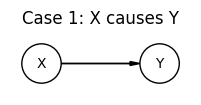

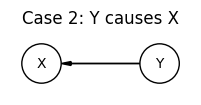

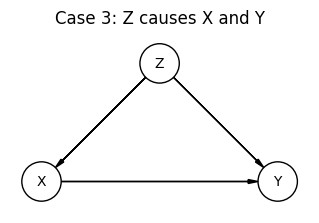

In [13]:
'''Create graph for case 1'''
V = PGM(grid_unit=3.0)

V.add_node("X", "X", 1, 1)
V.add_node("Y", "Y", 2, 1)
V.add_edge("X", "Y")

V.render()
plt.title('Case 1: X causes Y')


'''Create graph for case 2'''
V2 = PGM(grid_unit=3.0)

V2.add_node("X", "X", 1, 1)
V2.add_node("Y", "Y", 2, 1)
V2.add_edge("Y", "X")

V2.render()
plt.title('Case 2: Y causes X')


'''Create graph for case 3'''
V3 = PGM(grid_unit=3.0)
V3.add_node("X", "X", 1, 1)
V3.add_node("Y", "Y", 3, 1)
V3.add_node("Z", "Z", 2, 2)

V3.add_edge("Z", "X")
V3.add_edge("Z", "Y")
V3.add_edge("X", "Y")

V3.render()
plt.title('Case 3: Z causes X and Y')

plt.show()

## 2.2. Confounders, Colliders, Mediators & blocking paths

### 2.2.1. Confounders

Confounder is a variable that **influences both the independent variable and the dependent variable**, leading to a spurious association between them. Confounders can obscure the true relationship between the variables of interest, leading to incorrect conclusions if not properly accounted for. As shown in the graph below, Z is the confounder of X and Y.

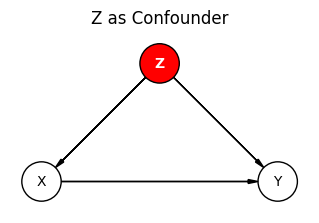

In [14]:
V = PGM(grid_unit=3.0)

V.add_node("X", "X", 1, 1)
V.add_node("Y", "Y", 3, 1)
V.add_node("Z", "Z", 2, 2,
           plot_params={'fc': 'r'}, 
           label_params={'color':'w', 'fontproperties': {'weight': 'heavy'}})

V.add_edge("Z", "X")
V.add_edge("Z", "Y")
V.add_edge("X", "Y")

V.render()

plt.title('Z as Confounder')
plt.show()

### 2.2.2. Colliders

A collider is a **variable that is influenced by two or more other variables**. Conditioning on a collider can lead to biased estimates if not done carefully, as it can induce spurious associations between variables that are not causally related. Let's take a look an example below.

Imagine you're studying the relationship between exercise (X) and heart health (Y), and you also know that diet (Z) affects heart health. Let's say that exercise and diet are independent of each other, meaning that one does not directly cause the other. In the equation, the relationship between X and Y would look like:

$Y = \beta_0 + \beta_1 \times X + \epsilon$

If you were to look at the data without considering diet (Z), you might find a strong association between exercise (X) and heart health (Y). However, this association might be misleading because diet (Z) also affects heart health and is related to exercise. When you include diet (Z) in your analysis by "conditioning on Z," you are essentially trying to isolate the effect of exercise (X) on heart health (Y) while accounting for the influence of diet. So, the equation would look like this now:

$Y = \beta_0 + \beta_1 \times X + \beta_2 \times Z + \epsilon$

However, conditioning on B can **create a "collider bias" because it opens up a pathway between exercise (A) and diet (B)**, which can then create a spurious association between exercise (A) and heart health (C). In this example, by conditioning on diet (B), which is a collider, you might mistakenly conclude that there is a direct causal relationship between exercise (A) and heart health (C) when, in fact, the association is due to the way the variables are related through diet.

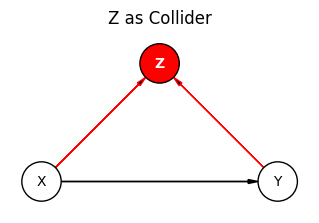

In [15]:
V = PGM(grid_unit=3.0)

V.add_node("X", "X", 1, 1)
V.add_node("Y", "Y", 3, 1)
# add node for collider
V.add_node("Z", "Z", 2, 2, 
           plot_params={'fc': 'r'}, 
           label_params={'color':'w', 'fontproperties': {'weight': 'heavy'}})

V.add_edge("X", "Z", plot_params={'ec': 'r'})
V.add_edge("Y", "Z", plot_params={'ec': 'r'})
V.add_edge("X", "Y")

V.render()

plt.title('Z as Collider')
plt.show()

### 2.2.3. Mediator

A mediator (M) is a **variable that explains the relationship between two other variables**. It is part of the causal pathway between an independent variable (X) and a dependent variable (Y). In other words, the mediator helps to understand how or why X influences Y. Conditioning on a mediator variable in a causal analysis can help to isolate and estimate the direct effect of the independent variable on the dependent variable, independent of the mediator's influence.

Let's use an analogy of the flow of a river. When considering causal relationships as directed flows, we can observe that a node (M) mediates the association between two other nodes (X and Y). This node acts as a mediator, transmitting the association between X and Y. To block this association, we simply need to keep M constant, similar to how a dam controls the flow of a river. This separation of M from X and Y helps us isolate and analyze the direct effects between two of them.

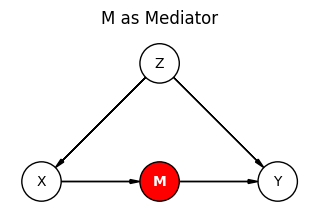

In [16]:
V = PGM(grid_unit=3.0)

V.add_node("X", "X", 1, 1)
V.add_node("Y", "Y", 3, 1)
V.add_node("Z", "Z", 2, 2)
V.add_node("M", "M", 2, 1, 
           plot_params={'fc': 'r'}, 
           label_params={'color':'w', 'fontproperties': {'weight': 'heavy'}})

V.add_edge("Z", "X")
V.add_edge("Z", "Y")
V.add_edge("X", "M")
V.add_edge("M", "Y")

V.render()

plt.title('M as Mediator')
plt.show()

### 2.2.4. D-Separation (Direct Separation)

The last concept we have to know before moving forward to the next section is d-separation. The concept of d-separation is used to determine whether two sets of variables in the graph are independent of each other given a third set of variables. This determination is made by examining the graph's structure to see if there are any paths between the sets of variables that are blocked or unblocked based on the configuration of the graph.

Understanding d-separation is important in causal inference and graphical modeling because it helps us to **determine whether variables are conditionally independent of each other** given certain conditions. This is crucial for identifying causal relationships and understanding the effects of variables in a causal pathway.

When considering d-separation along with concepts like colliders, confounders, and mediators, it becomes even more valuable.

1. **Colliders**: D-separation can help identify whether conditioning on a collider (a variable influenced by two other variables) opens or blocks a path between the two variables. This is important because conditioning on a collider can lead to biased estimates if not done carefully.

2. **Confounders**: D-separation can help identify whether there are unblocked paths between the treatment (independent variable) and the outcome (dependent variable) that pass through a confounder (a variable that influences both the treatment and the outcome). Conditioning on a confounder can help control for its effect and estimate the direct effect of the treatment on the outcome.

3. **Mediators**: D-separation can help identify paths that pass through a mediator (a variable that explains the relationship between the treatment and the outcome). Understanding these paths is crucial for mediation analysis, where we want to determine the direct and indirect effects of the treatment on the outcome through the mediator.

For more detailed information about these four definitions we have discussed, please take a look at Kenneth Styppa article about causal discovery <a href='https://medium.com/causality-in-data-science/confounding-colliding-d-separation-and-sleeping-with-shoes-on-8ba43c976354'>here.</a>

# 3. Causal Discovery

In causal inference, we encounter two distinct tasks depending on our objective.

- **Task 1:** This task involves using existing qualitative knowledge about causal relationships to construct a directed acyclic graph. This graph is then used to quantitatively estimate causal effects, a process known as causal effect estimation.
- **Task 2:** In contrast, this task begins with no prior knowledge about the relationships between variables. It involves an exploratory process to uncover these relationships, often referred to as causal discovery.

In this section, we will delve into the topic of causal discovery, explore a popular algorithm, and demonstrate how to implement it in Python.

## 3.1. PC Algorithm

The PC (Peter & Clark) algorithm is one of the popular algorithms used for causal discovery in Bayesian networks. It is popular as the way it works is pretty intuitive for someone who just starts learning about causal discovery. It is a constraint-based algorithm that uses conditional independence tests to determine the presence or absence of edges (directed edges representing causal relationships) in a Bayesian network. Here's a high-level overview of how the PC algorithm works:

1. **Initialize the graph**: Start with a fully connected undirected graph (all variables are connected to each other).

2. **Conditional Independence tests**:
   - For each pair of variables $(X)$ and $(Y)$, test if they are conditionally independent given a set of variables $(S)$, denoted as $(X \perp Y \,|\, S))$. This test determines if there is a direct causal relationship between $(X)$ and $(Y)$ after conditioning on $(S)$.
   - Start with S as the empty set S={} and increasing its size (cardinality) by 1 for every iteration.
   - Use statistical tests such as the chi-square test or mutual information to determine conditional independence.

3. **Remove edges based on conditional independence**:
   - If $(X \perp Y \,|\, S)$ holds, remove the edge between $(X)$ and $(Y)$ in the graph.
   - If $(X \not\perp Y \,|\, S)$, retain the edge between $(X)$ and $(Y)$ in the graph.

4. **Transitive closure**:
   - After all conditional independence tests are performed, apply the transitive closure to the graph. This involves removing edges that are implied by the remaining edges in the graph. 

4. **Establish causal direction**:
   - Establish (causal) directions for each remaining edge using colliders, the assumption that there are no cycles, and any other assumptions you can make use of, such as time order.
   - Will be discussed more details in a dedicated sub-section.

5. **Return the resulting graph**:
   - The final graph represents the causal relationships between variables as inferred by the PC algorithm.

The PC algorithm, moreover, is widely used for causal discovery due to its ability to handle large datasets and its scalability to high-dimensional data. However, it is important to note that the algorithm's performance can be influenced by factors such as the choice of conditional independence tests and the presence of latent variables.

Now let's do this by using a synthesized dataset.

### 3.1.1. Synthesized Dataset

We will now attempt to do the PC algorithm to reveal the causal discovery. But before that, let's create the sythesized dataset by ourselves where we already knew the structural of the causal model so we can use the PC algorithm to prove whether what we're doing is correct.

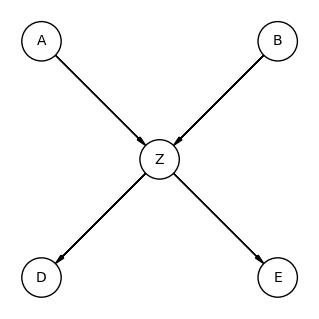

In [17]:
V = PGM(grid_unit=3.0)

V.add_node("A", "A", 1, 1)
V.add_node("B", "B", 3, 1)
V.add_node("Z", "Z", 2, 0)
V.add_node("D", "D", 1, -1)
V.add_node("E", "E", 3, -1)

V.add_edge("A", "Z")
V.add_edge("B", "Z")
V.add_edge("Z", "D")
V.add_edge("Z", "E")

V.render()

plt.show()

In [18]:
import numpy as np
import pandas as pd

np.random.seed(42)  # reproducibility

n_sample = 1000

# generate variables A and B as random integers between 0 and 10
a = np.random.randint(0, 10, size=n_sample)
b = np.random.randint(0, 10, size=n_sample)

# generate variable Z as the sum of A + B with added noises
z = a + b + np.random.normal(0, 1, size=n_sample)

# generate variable D and E as functions of Z with added noise
d = z + np.random.normal(0, 1, size=n_sample)
e = z + np.random.normal(0, 1, size=n_sample)

# put int dictionary
data = {'b': b, 'z': z, 'd':d, 'e':e, 'a': a}

df = pd.DataFrame(data)
df.head(5)

,b,z,d,e,a
0,0,4.131800,4.877901,4.218225,6
1,7,8.025863,6.400827,7.811688,3
2,3,11.042609,11.134788,10.959215,7
3,3,6.480147,6.163588,3.292335,4
4,4,8.350918,6.945163,9.033554,6


In [411]:
# save the df into our dataset folder
df.to_csv('dataset/data.csv')

### 3.1.2. Causal Discovery - No Library

In [19]:
from itertools import chain, combinations
import pingouin as pg

vars_lst = list(df.columns)
skeleton = list(combinations(vars_lst, 2))

def skeleton_result(data, vars_lst, skeleton):
    '''
    Conducts conditional independence tests to determine the final skeleton graph and creates a skeleton table.

    Parameters:
        - data (DataFrame): DataFrame containing information about the data we want to reveal it's skeleton.
        - vars_lst (list): List of variable names.
        - skeleton (list): List of variable combinations representing potential edges in the skeleton graph.

    Returns:
        - skeleton_table (DataFrame): DataFrame containing information about the edges, conditioning sets, p-values, removal status, and unshielded triples.
        - result (list): List of tuples representing the final skeleton graph edges after conditional independence tests.
    '''
    # we will remove edges one by one from this
    result = list(combinations(vars_lst, 2))

    # create the placeholder for the skeleton table
    skeleton_table = pd.DataFrame(columns=['node_1', 'node_2', 'edges', 's', 'p-val', 'removed'])
    i = 0

    for x, y in skeleton:
        
        # then define other vars for the covariates / variables to control for the independence tests
        other_vars = [var for var in vars_lst if var != x and var != y]
        all_combinations = list(chain.from_iterable(combinations(other_vars, r) for r in range(len(other_vars) + 1)))
        
        for comb in all_combinations:
            comb = list(comb)
            # remove edges X-Y if X is independent of Y given a conditioning set S
            # starting with S as the empty set S={} and increasing its size (cardinality) by 1 for every iteration.
            p_val = pg.partial_corr(data=data, x=x, y=y, covar=comb)['p-val'].values[0]

            skeleton_table.loc[i, 'node_1'] = x
            skeleton_table.loc[i, 'node_2'] = y
            skeleton_table.loc[i, 'edges'] = f'{x} - {y}'
            skeleton_table.loc[i, 's'] = comb
            skeleton_table.loc[i, 'p-val'] = p_val

            i += 1

            # eliminate as many edges as possible using conditional independence tests
            if p_val > 0.05: 
                try:
                    result.remove((x, y))
                except ValueError:
                    pass

    # now we fill in all the blank data in the skeleton_table
    # fill in the removed table with False, if it the edge hasn't been removed yet
    skeleton_table['removed'] = True

    for i in result:
        pairs = ' - '.join(i)
        skeleton_table.loc[skeleton_table['edges'] == pairs, 'removed'] = False

    # create ind_corr list for the next step of determining the causal direction
    ind_corr = skeleton_table[skeleton_table['p-val'] < 0.05].drop_duplicates('edges')['edges'].values

    print("final skeleton graph:", result)

    return skeleton_table, ind_corr, result

In [22]:
skeleton_table, ind_corr, result = skeleton_result(df, vars_lst, skeleton)
display(skeleton_table.sort_values(['removed', 'edges'])[['edges', 's', 'p-val', 'removed']])
print("edges that aren't independent:", ind_corr)

final skeleton graph: [('b', 'z'), ('z', 'd'), ('z', 'e'), ('z', 'a')]


,edges,s,p-val,removed
0,b - z,[],0.0,False
1,b - z,[d],0.0,False
2,b - z,[e],0.0,False
3,b - z,[a],0.0,False
4,b - z,"[d, e]",0.000021,False
...,...,...,...,...
75,e - a,[d],0.000028,True
76,e - a,"[b, z]",0.932996,True
77,e - a,"[b, d]",0.0,True
78,e - a,"[z, d]",0.196497,True


edges that aren't independent: ['b - z' 'b - d' 'b - e' 'b - a' 'z - d' 'z - e' 'z - a' 'd - e' 'd - a'
 'e - a']


### 3.1.3. Determining Causal Directions from the Skeleton

After establishing the final skeleton graph, the next step is to determine the direction of the arrows. There are two main approaches:

- **Utilizing Time Dependencies:** If A occurs before Z, the arrow points from A to Z.
- **Collider Rule:** Utilizing the collider structures to orient the graph.

While the time dependencies are straightforward, let's delve into the collider rule method.

The algorithm examines all **unshielded triples** in the skeleton. An unshielded triple, like A-Z-B, meets three criteria:

1. Node A is connected to node Z.
2. Node Z is connected to node B.
3. There is no direct edge between nodes A and B.

According to the collider rule, if Z was not part of the conditioning set in the statistical test that removed the A-B link, then the arrows must point to Z. Why? Without this, there would be a dependence between A and B (by d-separation), which was not observed. This aligns with the true causal graph.

This oriented collider structure aids in determining other orientations. For instance, there is no such collider for A-Z-E or other remaining triples. If there were a directed edge from E to Z, then A and E should be independent without any other variables (S={}). However, we found them to be independent given Z in the skeleton phase. Thus, we assume the arrow goes from Z to E. The same logic applies to the Z to D edge. This process allows us to direct all remaining edges and discover the true causal graph.

Now, let's move to the code.

In [41]:
def causal_direct_collider(skeleton_table, nodes, collider):
    '''
    Infers causal directions between nodes based on the skeleton_table with collider rule.

    Parameters:
        - skeleton_table (pd.DataFrame): DataFrame containing skeleton edges and other relevant data.
        - nodes (list): List of nodes to analyze.
        - collider (str): Collider variable to consider in causal inference.

    Returns:
        - pd.DataFrame: DataFrame containing inferred causal directions.
    '''
    # initialize empty DataFrames to store intermediate and final results
    causal_table = pd.DataFrame(columns=['from', 'dir', 'to'])
    final_causal_table = pd.DataFrame(columns=['from', 'dir', 'to'])

    # iterate over each pair of nodes
    for node in nodes:

        # filter the skeleton table to get relevant edges for the current node pair
        result = skeleton_table[
            (skeleton_table['node_1'].isin([node[0], node[1]])) & 
            (skeleton_table['node_2'].isin([node[1], node[0]]))
        ]
        
        records = []

        # check if there are significant edges for the current node pair
        # if there are significant edges, add them to the records
        if len(result[(result['p-val'] > 0.05) & result['s'].apply(lambda x: collider not in x)]) > 0:
            
            for n in node:
                records.append({'from': n, 'to': collider})

            causal_table = pd.concat([causal_table] + [pd.DataFrame(records)], ignore_index=True)

        # if there are no significant edges, add the reverse direction to the records
        else:
            result = result.loc[result['s'].values == 'z', 'p-val'] > 0.05
            for n in node:
                new_record = {'from': collider, 'to': n}
                records.append(new_record)

                causal_table = pd.concat([causal_table] + [pd.DataFrame(records)], ignore_index=True)
        
        final_causal_table = pd.concat([final_causal_table] + [causal_table])
        final_causal_table = final_causal_table.drop_duplicates(ignore_index=True)


    # remove edges that violate the causal direction
    # meaning that, prioritize the first rule, then second
    # if there's a conflict, then prioritize the first rule

    for i in range(len(final_causal_table)):
        if final_causal_table.loc[i, 'from'] == collider:
            if final_causal_table.loc[i, 'to'] in final_causal_table['from'].values:
                final_causal_table.drop(i, inplace=True)

    # last step, tidying up the dataframe
                
    final_causal_table['dir'] = '->'
    final_causal_table.reset_index(drop=True, inplace=True)
    
    # put it into a list so we can pass it directly later for causal effect size
    final_causal_list = list(zip(final_causal_table['from'], final_causal_table['to']))
    print(final_causal_list)

    return final_causal_table, final_causal_list

In [43]:
causal_table, causal_list = causal_direct_collider(skeleton_table, [['b', 'a'], ['a', 'd'], ['b', 'e'], ['d', 'e']], collider='z')
causal_table

[('b', 'z'), ('a', 'z'), ('z', 'd'), ('z', 'e')]


,from,dir,to
0,b,->,z
1,a,->,z
2,z,->,d
3,z,->,e


Completed! We have conducted causal inference analysis using the PC algorithm. To simplify the process and enable you to follow along independently, I have created a **Python library for this purpose**, which you can find in the app folder. Below, I will demonstrate how to invoke the library and perform the analysis, similar to the example above.

In [25]:
import app.causal_discovery as cd

# invoke a causal discovery instance
# then we can print the result and save it into the skeleton_table

cd_instance = cd.CausalDiscovery(data=df, vars_lst=vars_lst, skeleton=skeleton)
skeleton_table, _, _ = cd_instance.skeleton_result()

final skeleton graph: [('b', 'z'), ('z', 'd'), ('z', 'e'), ('z', 'a')]


In [26]:
nodes = [['b', 'a'], ['a', 'd'], ['b', 'e'], ['d', 'e']]
collider = 'z'

# after we call the skeleton_result() method to the instance, it will save the skeleton_table to the cd_instance
# then we can call the causal_direct_collider() method to know the causal direction

cd_instance.causal_direct_collider(nodes, collider)

,from,dir,to
0,b,->,z
1,a,->,z
2,z,->,d
3,z,->,e


### 3.1.4. Causal Discovery - PGMpy

The code above provides a detailed, step-by-step explanation of how the PC algorithm works, helping to understand the concept behind it. However, for a more efficient approach, we can use the `pgmpy` library, a **Python library designed for working with Probabilistic Graphical Models**. Using this library, we can implement the PC algorithm by simply passing the data to the `PC` class. The following code demonstrates this simplified implementation.

In [28]:
from pgmpy.estimators import PC

est = PC(data=df)
model = est.estimate(ci_test='pearsonr')

print("Edges of the Estimated Causal Graph:")
print(model.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

Edges of the Estimated Causal Graph:
[('b', 'z'), ('z', 'd'), ('z', 'e'), ('a', 'z')]


# 4. Causal Effect Size

After identifying causal relationships, the next step is to estimate the magnitudes of these effects. Several methodologies can be employed:

1. **Linear Regression:** This method can be used if the data allows. For each identified causal relationship, regress the dependent variable on the independent variable(s) to estimate the effect size.

2. **Structural Equation Modeling (SEM):** SEM is another approach to estimate effect sizes. It involves specifying a model based on the causal structure and then estimating parameters to determine the effect sizes.

3. **Path Analysis:** Path analysis, a subset of SEM, focuses on estimating direct and indirect effects. It is useful for quantifying the effect sizes of identified causal paths.

4. **Standardized Coefficients:** In linear regression or SEM, standardizing coefficients can make them comparable across different variables, aiding in understanding the relative importance of different causal paths.

5. **Bayesian Methods:** Bayesian methods provide a posterior distribution of effect sizes, offering a range of plausible values along with their uncertainties.

Since linear regression is relatively easy to perform, this notebook will focus on methodologies that are less commonly adopted due to their complexity: **Bayesian Methods and SEM + Path Analysis.** These approaches offer more nuanced insights but require a deeper understanding of their underlying principles and methodologies.

## 4.1. Bayesian Methods

Here, we will approach the problem using the Bayesian approach, which differs from the Frequentist approach in its underlying philosophy. In Bayesian inference, we update our beliefs about the parameters of interest (the posterior) based on both our prior beliefs (the prior), the evidence or data we have, and the likelihood function which represents the probability of observing the data given specific values of the parameters. This approach allows us to incorporate existing knowledge or assumptions into our analysis and update them as we gather more evidence. By contrast, the Frequentist approach typically does not involve prior beliefs and focuses on the frequency or probability of observed data under certain assumptions.

One challenging aspect of calculations in the Bayesian approach is the need to specify the prior distribution. It's important to note that different distributions require different classes in the PGMpy library. I suggest referring to their documentation for more details.

For categorical data, you can refer to the Bayesian method documentation here: [Bayesian Method for Categorical Data](https://pgmpy.org/param_estimator/bayesian_est.html). For continuous data, follow the instructions provided in the second link: [Bayesian Method for Continuous Data](https://pgmpy.org/detailed_notebooks/7.%20Parameterizing%20with%20Continuous%20Variables.html). Since our data is continuous, we will follow the instructions from the second link.

Before moving forward, let's talk a little bit about the concept of **Bayesian Network** and why is it important for us to understand about it.

### 4.1.1. Bayesian Network

By Wikipeida, Bayesian network is defined as a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). So, Bayesian network consists of two key components:

- **Directed Acyclic Graph (DAG):** This graph depicts the causal structure. Variables are represented by nodes, and arrows between nodes indicate causal relationships. A variable can only be directly influenced by its parent nodes in the graph (acyclic means no loops exist).
- **Conditional Probability Distributions (CPDs)**: Each node in the BN has a CPD associated with it. This CPD specifies the probability distribution of that node's value given the values of its parent nodes.

We already discussed the DAG previously in depth. But, what does actually CPD mean?

A CPD is a mathematical object that represents the **probability distribution of a single child variable in a BN given the values of its parent nodes in the DAG.** It essentially tells you "how likely" a specific value for the child node is, considering the values of its parents.

The format of the CPD depends on the type of variable it represents:
- **Discrete Variables:** The CPD is typically a table that specifies the probability of each possible value for the child node given every combination of values for its parent nodes.
- **Continuous Variables:** Specific CPDs like LinearGaussianCPDs are used. These models the relationship between the child node and its parents as a linear function with added Gaussian noise (normal distribution).

If all of these still sound confusing for you, let's take a look at an example.

#### Example: Disease, Symptom, and Doctor Visit:

Let's revisit the BN example with three variables: Disease (D), Symptom (S), and Doctor Visit (V). 

- The DAG is D -> S, D -> V (disease causes both symptoms and doctor visits). 
- Imagine Disease (D) can be either "Yes" or "No," Symptom (S) can be "Yes" or "No," and Doctor Visit (V) can be "Yes" or "No." 

The CPD for Symptom (S) would be a table like this:

| Disease (D) | P(Symptom=Yes \| D) | P(Symptom=No \| D) |
|-------------|----------------------|---------------------|
| Yes         | 0.8 (80% chance of symptom if disease is present) | 0.2 (20% chance of no symptom) |
| No          | 0.1 (10% chance of symptom even without disease) | 0.9 (90% chance of no symptom) |

The CPDs would specify probabilities like "P(Symptom=Yes | Disease=Yes)" or "P(Doctor Visit=Yes | Disease=No)".

So, why is it important to learn Bayesian Network? Causal inference aims to understand how changes in one variable cause changes in another. BNs are powerful tools for causal inference because:

- **They encode causal structure:** The DAG explicitly represents which variables influence others, aiding in reasoning about cause-and-effect relationships.
- **They allow for probabilistic reasoning:** By combining the CPDs with Bayes' theorem, you can calculate the probability of any variable's value given evidence (observations) about other variables. This helps estimate the effect of one variable on another.

Next, how can we calculate these CPDs? Now, let's take a look at the second concept: Bayesian Network Factorization.

### 4.1.2. Bayesian Network Factorization

Bayesian Network Factorization is a principle in Bayesian Networks that expresses the joint probability distribution (JPD) of all variables in the network as a product of smaller conditional probability distributions (CPDs).

- The JPD represents the probability of all possible combinations of values for all variables in the BN. It captures the complete picture of how the variables are related probabilistically.
- Factorization breaks down the JPD into smaller, more manageable CPDs. Each CPD represents the probability distribution of a single variable given the values of its parent nodes in the Directed Acyclic Graph (DAG) of the BN.
- By multiplying these individual CPDs, based on the specific structure of the DAG, you can reconstruct the full JPD.

The general formula for Bayesian Network Factorization can be expressed as follows:

$P(x_1, x_2, ..., x_n) = \prod P(x_i | \text{Parents}(x_i))$

where:

- $x_1, x_2, ..., x_n$ represent all the variables in the network.
- $\prod$ (product symbol) indicates that we're multiplying all the terms together.
- $P(x_i | \text{Parents}(x_i)$ is the CPD for variable $x_i$, conditioned on the values of its parent nodes in the DAG. $\text{Parents}(x_i)$ refers to the set of parent nodes for variable $x_i$.

Let's take an example to make it easier to grasp.

Imagine a BN with four variables:

- Weather (W): Can be "Sunny" or "Rainy"
- Sprinklers (S): Can be "On" or "Off"
- Grass Wetness (G): Can be "Wet" or "Dry"
- Car Wash (C): Can be "Yes" or "No"

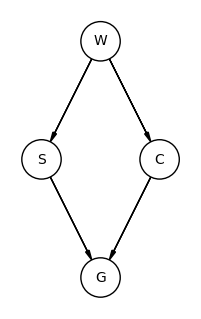

In [131]:
# let's create the causal graph first

V = PGM(grid_unit=3.0)

V.add_node("W", "W", 1.5, 1)
V.add_node("S", "S", 1, 0)
V.add_node("C", "C", 2, 0)
V.add_node("G", "G", 1.5, -1)

V.add_edge("W", "S")
V.add_edge("W", "C")
V.add_edge("S", "G")
V.add_edge("C", "G")

V.render()
plt.show()

Using the general formula for Bayesian Network Factorization, we can express the joint probability of all variables (P(W, S, G, C)) as:

$P(W, S, G, C) = P(W) * P(S | W) * P(C) * P(G | W, S, C)$

- **P(W):** This is the marginal probability distribution of Weather (independent of other variables). It represents the likelihood of it being sunny or rainy irrespective of the other factors.
- **P(S | W):** This is the CPD for Sprinklers conditioned on Weather. It specifies the probability of the sprinklers being on or off given the weather (sunny or rainy). For example, it might be more likely to use sprinklers if it's sunny.
- **P(C):** This is the marginal probability distribution of Car Wash (independent of other variables). It represents the likelihood of having a car wash irrespective of the weather or sprinkler usage.
- **P(C | W):** This is the CPD for Car Wash conditioned on Weather.
- **P(G | W, S, C):** This is the most complex term. It's the CPD for Grass Wetness conditioned on all its parent nodes: Weather (W), Sprinklers (S), and Car Wash (C). 

Once you have defined the specific CPDs for each variable (which might involve tables for discrete variables or parameters for continuous variables like LinearGaussianCPDs), you can use the factorization formula to calculate the probability of any combination of values for all variables. For instance, you could calculate the probability of having wet grass (G="Wet") given sunny weather (W="Sunny"), sprinklers off (S="Off"), and no car wash (C="No"). This would involve using the specific values from the relevant CPDs (P(W="Sunny"), P(S="Off" | W="Sunny"), and P(G="Wet" | W="Sunny", S="Off", C="No")) and multiplying them together according to the factorization formula.

So why do we need Bayesian Network Factorization?

- **Efficiency:** Breaking down the joint probability into smaller CPDs makes calculations more manageable, especially for large networks.
- **Transparency:** The factorization highlights the influence of parent nodes on their child nodes, making the causal structure clearer.
- **Inference:** You can use the factorization and Bayes' theorem to perform probabilistic reasoning and causal inference tasks within the BN.

### 4.1.3. Theory to the Action

Now, let's apply the theory to our previous data. Manual calculations would be challenging, so we'll use the PGMpy library instead. In this section, we will:

1. Create a regression model using the linear model from statsmodels as the benchmark.
2. Define the model using a Bayesian Network.
3. Perform inference from the Bayesian Network and compare it with regression model.

Note that the approach for specifying data for continuous and categorical variables differs. I recommend referring to the PGMpy documentation for a better understanding of how to handle categorical variables.

In [135]:
# refresh and take a look again at the data we have

display(df.head())
display(causal_list)

,b,z,d,e,a
0,0,4.131800,4.877901,4.218225,6
1,7,8.025863,6.400827,7.811688,3
2,3,11.042609,11.134788,10.959215,7
3,3,6.480147,6.163588,3.292335,4
4,4,8.350918,6.945163,9.033554,6


[('b', 'z'), ('a', 'z'), ('z', 'd'), ('z', 'e')]

In [301]:
# let's use a simple model first using a linear regression as a benchmark and comparison
# a -> z and b -> z

import statsmodels.api as sm

X = df[['a', 'b']]
X = sm.add_constant(X)
y = df['z']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      z   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     8258.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        10:56:39   Log-Likelihood:                -1435.1
No. Observations:                1000   AIC:                             2876.
Df Residuals:                     997   BIC:                             2891.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0094      0.077      0.123      0.902      -0.141       0.160
a              0.9938      0.011     89.868      0.000       0.972       1.015
b              1.0085      0.011     91.482      0.000       0.987       1.030
==============================================================================
Omnibus:                        0.106   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.948   Jarque-Bera (JB):                0.081
Skew:                          -0.022   Prob(JB):                        0.960
Kurtosis:                       3.007   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [296]:
# now, let's use 10% sample of the data for the prior distribution
import math

mean_prior = {}
std_prior = {}

for col in df.columns:
    mean_prior[col] = df[col].sample(100).mean()
    std_prior[col] = math.sqrt(df[col].sample(100).var())

In [302]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.continuous import ContinuousFactor
from scipy.stats import norm

# now, let's specify and build the model

# specify prior probability distribution for all variables
# assuming that all of the variables are normally distributed
def pdf_a(x, mean=mean_prior['a'], std=std_prior['a']):
    return norm.pdf(x, loc=mean, scale=std)

def pdf_b(x, mean=mean_prior['b'], std=std_prior['b']):
    return norm.pdf(x, loc=mean, scale=std)

def pdf_z(x, mean=mean_prior['z'], std=std_prior['z']):
    return norm.pdf(x, loc=mean, scale=std)

def pdf_d(x, mean=mean_prior['d'], std=std_prior['d']):
    return norm.pdf(x, loc=mean, scale=std)

def pdf_e(x, mean=mean_prior['e'], std=std_prior['e']):
    return norm.pdf(x, loc=mean, scale=std)

model = BayesianNetwork(causal_list)

# Define the CPDs with the custom PDF functions
cpd_a = ContinuousFactor(['a'], pdf_a)
cpd_b = ContinuousFactor(['b'], pdf_b)
cpd_z = ContinuousFactor(['z'], pdf_z)
cpd_d = ContinuousFactor(['d'], pdf_d)
cpd_e = ContinuousFactor(['e'], pdf_d)

# Add the CPDs to the model
model.add_cpds(cpd_a, cpd_b, cpd_z, cpd_d, cpd_e)
model.fit(df)

### 4.1.4. Inference from Bayesian Network

Now, how can we draw conclusions from a Bayesian Network? As you may already know from the Bayesian approach, the outcome we obtain is a posterior distribution that depicts all possible values and their probabilities, thus addressing the uncertainty in the result. The same principle applies here. A notable difference between deriving inference from a Bayesian Network and a regression result is that we do not obtain the coefficient or effect size. Instead, we derive statements like:

**"The probability of x given y and z is..."**

Here, y and z represent the parents of x. Let's consider the following example after fitting the model to our data.

In [346]:
from pgmpy.inference import VariableElimination

# taking the inference
# pass the query with what variable we want to know
# pass evidence with the values of parent

inference = VariableElimination(model)
result = inference.query(['z'], evidence={'a': 6, 'b': 0})

In [383]:
# now, we can make either a pdf or kde plot
# but first, let's put the data into the variables first

values = df['z'].sort_values().values
probabilities = result.values

data = {'values': values, 'probabilities': probabilities}
df_inference = pd.DataFrame(data)

# we can now check where the probability is not zero
display(df_inference[df_inference['probabilities'] > 0])
print('taking account of all probability, the mean would be:', df_inference[df_inference['probabilities'] > 0]['values'].mean())

,values,probabilities
144,4.131800,0.125
168,4.437345,0.125
236,5.638355,0.125
283,6.353207,0.125
313,6.793056,0.125
334,7.069608,0.125
336,7.085594,0.125
404,7.774213,0.125


taking account of all probability, the mean would be: 6.160397219370321


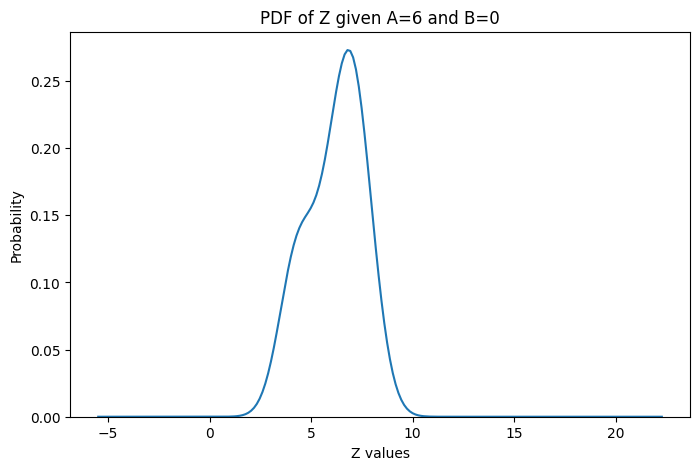

In [350]:
import seaborn as sns

# and plot it with a KDE

plt.figure(figsize=(8, 5))
sns.kdeplot(values, weights=probabilities, cumulative=False)
plt.xlabel('Z values')
plt.ylabel('Probability')
plt.title('PDF of Z given A=6 and B=0')

plt.show()

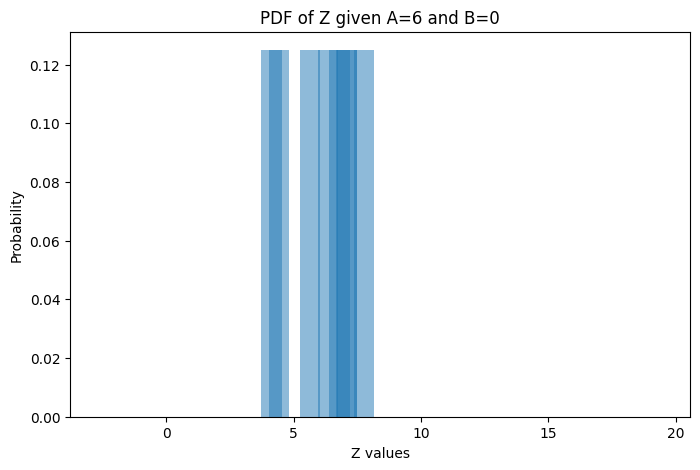

In [351]:
# or in a PDF barplot

plt.figure(figsize=(8, 5))
plt.bar(values, probabilities, align='center', alpha=0.5)
plt.xlabel('Z values')
plt.ylabel('Probability')
plt.title('PDF of Z given A=6 and B=0')

plt.show()

### 4.1.5. Comparing Result with Regression

In [370]:
import statsmodels.api as sm

X = df[['a', 'b']]
X = sm.add_constant(X)
y = df['z']

model = sm.OLS(y, X).fit()
model.summary()

new_data = pd.DataFrame({'const': 1, 'a': [6], 'b': [0]})
prediction = model.predict(new_data)

print('with a regression model, given A = 6 and B = 0, Z =', prediction.values[0])

with a regression model, given A = 6 and B = 0, Z = 5.97209092319203


## 4.2. Path + Structural Equation Modeling (SEM)

Structural Equation Modeling (SEM) is a statistical technique used to test and estimate causal relationships using a combination of statistical data and qualitative causal assumptions. It is not only one statistical method, but it's like a collection and diverse set of methods of statistical tests. It allows researchers to specify and test complex relationships among variables, including direct and indirect effects, mediation, moderation, and latent variable constructs.

To understand SEM, let's take a look at some terms that you must be familiar with in advance before moving forward with SEM:

- **Path Diagrams:** These diagrams visually represent the proposed causal relationships among variables in an SEM. They include observed variables (measured directly) and latent variables (not directly measured but inferred from observed variables).

- **Measurement Models:** These models describe the relationships between latent variables and their observed indicators. They help assess the reliability and validity of the measurement instruments.

- **Structural Models:** These models specify the relationships between latent variables and/or observed variables. They allow researchers to test hypotheses about the relationships among variables.

- **Model Fit:** SEM uses various fit indices (e.g., chi-square, RMSEA, CFI) to assess how well the proposed model fits the data. Good model fit indicates that the model accurately represents the relationships among the variables.

- **Causality vs. Correlation:** SEM can test causal relationships, but it does not prove causality. It provides evidence for or against hypothesized causal relationships based on the data and the model.

- **Assumptions:** SEM assumes that the data are normally distributed, the relationships among variables are linear, and the measurement instruments are reliable and valid.

- **Interpretation:** Interpreting SEM results involves understanding the estimated coefficients (path coefficients), standard errors, and significance levels. It also involves examining the overall model fit and the fit of individual paths.

SEM is commonly utilized to test hypotheses regarding relationships among variables within a predefined theoretical model. It is not ideal for exploratory analysis when the relationships between variables are unknown beforehand. While we won't go into the theory behind SEM here. If you're interested into learning more about SEM, I suggested you to check this <a href='https://medium.com/@anand.abhishek2901/structural-equation-model-a-powerful-modeling-framework-cc410023570b'>link</a> out.

SEM is particularly effective when attempting to measure **latent variables, which are not directly observed but inferred from other observed variables** (manifest variables). For instance, in a psychological study, researchers might seek to measure "intelligence." Since intelligence cannot be directly measured, researchers might use observable variables like academic performance, problem-solving ability, and memory recall to infer the latent variable of intelligence.

In our example here, we do not have any latent variables. However, as SEM is proficient in measuring the effect sizes of all nodes, we will employ it to comprehend the causal effect size in our causal structure.

### 4.2.1. Semopy

There's only a scarce number of people who made a Python library dedicated to library. However there's one library called "Semopy" which is is designed to help statisticians that employ SEM techniques to handle their research in a more Pythonic way. We will use this library on this example below, but before that, let's take a look at the syntax on how to build the equation in Semopy.

| Description                         | Syntax ex.           |
|-------------------------------------|---------------------|
| Regression operator (~)             | y ~ x1 + x2 + x3   |
| Latent factor to variables (=~)     | eta =~ y1 + y2 + y3 |
| Covariance operator (~~)            | a ~~ b + c         |

### 4.2.2. Semopy in Action

In [410]:
import semopy as sem
from semopy import Model

# define the causal structure first
# using a docstring to make it readable
desc = '''
    z ~ a + b
    d ~ z
    e ~ z
    '''

# fit the causal structure into the model
mod = Model(desc)
mod.fit(df)

# like statsmodels, we can use something similar to summary to inspect the result
mod.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,z,~,a,0.993783,0.011042,89.996549,0.0
1,z,~,b,1.008565,0.011009,91.614098,0.0
2,d,~,z,0.993564,0.007556,131.498259,0.0
3,e,~,z,1.017169,0.007277,139.775027,0.0
4,z,~~,z,1.032935,0.046194,22.360680,0.0
5,d,~~,d,1.035706,0.046318,22.360680,0.0
6,e,~~,e,0.960754,0.042966,22.360680,0.0


Now, we can evaluate the SEM model we built previously using `calc_stats` method. In `semopy`, the `calc_stats` method is used to calculate fit indices for a fitted SEM model. These fit indices help to evaluate how well the model fits the observed data. The fit indices available in `semopy` include:

1. **χ² (Chi-square):** A goodness-of-fit measure that compares the observed covariance matrix with the model-implied covariance matrix. A lower χ² value indicates a better fit, but it is sensitive to sample size.

2. **RMSEA (Root Mean Square Error of Approximation):** Measures the discrepancy between the model-implied covariance matrix and the observed covariance matrix, adjusted for model complexity. A lower RMSEA value indicates a better fit, with values below 0.05 indicating close fit.

3. **CFI (Comparative Fit Index):** Compares the fit of the specified model with a null model in which all variables are uncorrelated. Values close to 1 indicate a good fit, with values above 0.95 often considered acceptable.

4. **TLI (Tucker-Lewis Index):** Similar to CFI, TLI compares the specified model with a null model. Values above 0.95 are often considered indicative of a good fit.

5. **NFI (Normed Fit Index):** Compares the fit of the specified model with a null model. Values range from 0 to 1, with values closer to 1 indicating a better fit.

6. **GFI (Goodness-of-Fit Index):** Measures the proportion of variance in the observed data that is explained by the model. Values close to 1 indicate a good fit.

7. **AGFI (Adjusted Goodness-of-Fit Index):** Similar to GFI, but adjusted for model parsimony. Values close to 1 indicate a good fit.

These fit indices provide different perspectives on the goodness of fit of an SEM model and can be used together to assess the overall fit of the model.

In [404]:
sem.calc_stats(mod)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,8,12,5.751496,0.675045,8800.348921,1.000256,0.999346,0.99902,0.999346,1.000384,0,13.988497,48.342784,0.005751


Then, we can also print the graph and it's coefficient + p-value using `semplot` method.

In [405]:
g = sem.semplot(mod, 'image/model.png')

![Result of the model from semopy.](image/model.png)